# 1. Nhập dữ liệu

In [11]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_test_path = "../../data_for_modeling/filter_data/all_data/clean_data/HDAC2_train_test_unclean_data_all.xlsx"; 
train_dataset = pd.read_excel(train_test_path, sheet_name='train_dataset')
test_dataset = pd.read_excel(train_test_path, sheet_name='test_dataset')

# 2. Xây dựng mô hình với Morgan2

## 2.1. Mã hóa cấu trúc phân tử

In [3]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i)
        fpts = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)
    return np.array(Morgan_fpts)

In [5]:
X_Train = morgan_fpts(train_dataset['SMILES'])
X_Test = morgan_fpts(test_dataset['SMILES'])
y_Train = np.array(train_dataset['FINAL_LABEL'])
y_Test = np.array(test_dataset['FINAL_LABEL'])

In [10]:
print(y_Train[0:5])
print(y_Test[0:5])

['Active' 'Inactive' 'Active' 'Active' 'Active']
['Active' 'Active' 'Active' 'Active' 'Active']


In [12]:
import sklearn.preprocessing as preprocessing
y_Train = preprocessing.LabelEncoder().fit_transform(y_Train)
y_Test = preprocessing.LabelEncoder().fit_transform(y_Test)

In [13]:
print(y_Train[0:5])
print(y_Test[0:5])

[0 1 0 0 0]
[0 0 0 0 0]


## 2.2. Xây dựng mô hình

__Random Forest Classifier__

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf_morgan2 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rf_morgan2.fit(X_Train, y_Train)

RandomForestClassifier(criterion='entropy', random_state=0)

__K Nearest Neighbor__

In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn_morgan2 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_morgan2.fit(X_Train, y_Train)

KNeighborsClassifier()

__SVM__

In [29]:
from sklearn.svm import SVC
svm_morgan2 = SVC(kernel='rbf', random_state=0, probability=True)
svm_morgan2.fit(X_Train, y_Train)

SVC(probability=True, random_state=0)

__XGBoost__

In [17]:
from xgboost import XGBClassifier
bst_morgan2 = XGBClassifier(n_estimators=100, objective='binary:logistic')
bst_morgan2.fit(X_Train, y_Train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 2.3. Đánh giá và so sánh mô hình của tác giả

### 2.3.1. 10-fold-cross validation

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [19]:
X_Total = np.concatenate((X_Train, X_Test), axis=0)
y_Total = np.concatenate((y_Train, y_Test), axis=0)

In [30]:
#KNN
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(knn_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation - KNN: %.3f (%.3f)' % (scores.mean(), scores.std()))

#RF
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(rf_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation - RF: %.3f (%.3f)' % (scores.mean(), scores.std()))

#SVM
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(svm_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation - SVM: %.3f (%.3f)' % (scores.mean(), scores.std()))

#XgBoost
cv = KFold(n_splits=10, random_state=1, shuffle=True)
scores = cross_val_score(bst_morgan2, X_Total, y_Total, scoring='accuracy', cv=cv, n_jobs=-1)
print('Độ chính xác của 10-fold cross validation - XgBoost: %.3f (%.3f)' % (scores.mean(), scores.std()))

Độ chính xác của 10-fold cross validation - KNN: 0.783 (0.025)
Độ chính xác của 10-fold cross validation - RF: 0.831 (0.029)
Độ chính xác của 10-fold cross validation - SVM: 0.809 (0.039)
Độ chính xác của 10-fold cross validation - XgBoost: 0.818 (0.034)


### 2.3.2. Accuracy, Sensitivity, Specificity

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
import math

In [32]:
def model_evaluation_calculation(cm):
    tp = cm[0][0]; tn = cm[1][1]; fp = cm[0][1]; fn = cm[1][0]
    ac = (tp+tn)/(tp+tn+fp+fn)
    se = tp/(tp+fn)
    sp = tn/(tn+fp)
    mcc = (tp*tn - fp*fn) / math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return ac, se, sp, mcc

In [33]:
def me_result(cm):
    print("Confusion matrix:")
    print(cm)
    ac, se, sp, mcc = model_evaluation_calculation(cm)
    print("Comparision:")
    table = [[' ' 'AC', 'SE', 'SP', 'MCC'], ['My model', ac, se, sp, mcc]]
    print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

In [34]:
#KNN
y_knn_pred = knn_morgan2.predict(X_Test)
print("KNN: ")
cm = confusion_matrix(y_Test, y_knn_pred)
me_result(cm)

#Random Forest
y_rf_pred = rf_morgan2.predict(X_Test)
print("RF:")
cm = confusion_matrix(y_Test, y_rf_pred)
me_result(cm)

#SVM
y_svm_pred = svm_morgan2.predict(X_Test)
print("SVM:")
cm = confusion_matrix(y_Test, y_svm_pred)
me_result(cm)

#XgBoost
y_bst_pred = bst_morgan2.predict(X_Test)
cm = confusion_matrix(y_Test, y_bst_pred)
me_result(cm)

KNN: 
Confusion matrix:
[[180  51]
 [ 47 150]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.771028 │ 0.792952 │ 0.746269 │ 0.539931 │
╘══════════╧══════════╧══════════╧══════════╧══════════╛
RF:
Confusion matrix:
[[185  46]
 [ 44 153]]
Comparision:
╒══════════╤═════════╤═════════╤══════════╤═════════╕
│          │      AC │      SE │       SP │     MCC │
╞══════════╪═════════╪═════════╪══════════╪═════════╡
│ My model │ 0.78972 │ 0.80786 │ 0.768844 │ 0.57711 │
╘══════════╧═════════╧═════════╧══════════╧═════════╛
SVM:
Confusion matrix:
[[174  57]
 [ 37 160]]
Comparision:
╒══════════╤══════════╤══════════╤══════════╤══════════╕
│          │       AC │       SE │       SP │      MCC │
╞══════════╪══════════╪══════════╪══════════╪══════════╡
│ My model │ 0.780374 │ 0.824645 │ 0.737327 │ 0.563698 │
╘══════════╧══════════╧══════════╧══════

### 2.3.3. AUC

In [35]:
from sklearn.metrics import RocCurveDisplay

In [36]:
from sklearn.metrics import roc_auc_score
knn_y_proba = knn_morgan2.predict_proba(X_Test)[:, 1]
rf_y_proba = rf_morgan2.predict_proba(X_Test)[:, 1]
svm_y_proba = svm_morgan2.predict_proba(X_Test)[:, 1]
bst_y_proba = bst_morgan2.predict_proba(X_Test)[:, 1]


knn_auc_score = roc_auc_score(y_Test, knn_y_proba)
rf_auc_score = roc_auc_score(y_Test, rf_y_proba)
svm_auc_score = roc_auc_score(y_Test, svm_y_proba)
bst_auc_score = roc_auc_score(y_Test, bst_y_proba)
print(knn_auc_score, rf_auc_score, svm_auc_score, bst_auc_score)

0.8621860373129409 0.885676928824137 0.8717120443008768 0.8927857252730349


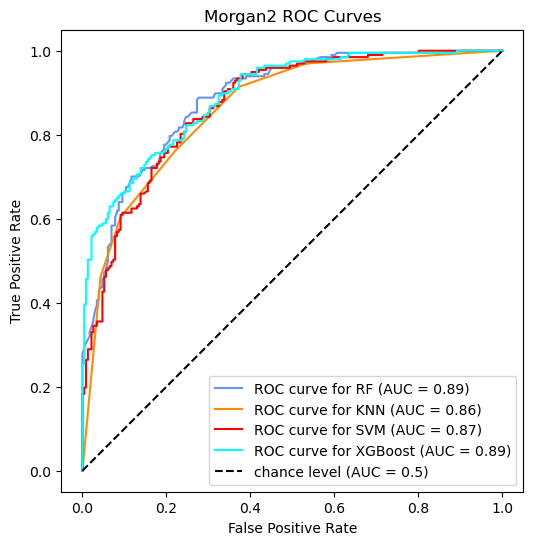

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))

RocCurveDisplay.from_estimator(
    estimator=rf_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for RF",
    color='cornflowerblue',
    ax=ax)


RocCurveDisplay.from_estimator(
    estimator=knn_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for KNN",
    color='darkorange',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=svm_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for SVM",
    color='red',
    ax=ax)

RocCurveDisplay.from_estimator(
    estimator=bst_morgan2, 
    X=X_Test, 
    y=y_Test,
    name=f"ROC curve for XGBoost",
    color='aqua',
    ax=ax)

plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Morgan2 ROC Curves")
plt.legend()
plt.show()